# Underdamped Langevin Diffusion simulation

The Underdamped Langevin diffusion (ULD) is an SDE of the form:

\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t,
\end{align*}

where $\mathbf{x}_t, \mathbf{v}_t \in \mathbb{R}^d$ represent the position
and velocity, $W$ is a Brownian motion in $\mathbb{R}^d$,
$f: \mathbb{R}^d \rightarrow \mathbb{R}$ is a potential function, and
$\gamma , u \in \mathbb{R}^{d \times d}$ are diagonal matrices governing
the friction and the dampening of the system.

## ULD for Monte Carlo and Bayesian inference

ULD is commonly used in Monte Carlo applications since it allows us to sample from its stationary distribution $p = \frac{\exp(-f)}{C}$ even when its normalising constant $C = \int p(x) dx$ is unknown. This is because only knowledge of $\nabla f$ is required, which doesn't depend on $C$. For an example of such an application see section 5.2 of the paper on [Single-seed generation of Brownian paths](https://arxiv.org/abs/2405.06464).

## ULD solvers in Diffrax

In addition to generic SDE solvers (which can solve any SDE including ULD), Diffrax has some solvers designed specifically for ULD. These are `diffrax.ALIGN` which has a 2nd order of strong convergence, and `diffrax.QUICSORT` and `diffrax.ShOULD` which are 3rd order solvers. Note that unlike ODE solvers which can have orders of 5 or even higher, very few types of SDEs permit solvers with a strong order greater than $\frac{1}{2}$.

These Langevin-specific solvers only accept terms retuned by `diffrax.make_langevin_term`.

## A 2D harmonic oscillator

In this example we will simulate a simple harmonic oscillator in 2 dimensions. This system is given by the potential $f(x) = x^2$.

In [7]:
from warnings import simplefilter


simplefilter(action="ignore", category=FutureWarning)
import diffrax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt


t0, t1 = 0.0, 20.0
dt0 = 0.05
saveat = diffrax.SaveAt(steps=True)

# Parameters
gamma = jnp.array([2, 0.5], dtype=jnp.float32)
u = jnp.array([0.5, 2], dtype=jnp.float32)
x0 = jnp.zeros((2,), dtype=jnp.float32)
v0 = jnp.zeros((2,), dtype=jnp.float32)
y0 = (x0, v0)

# Brownian motion
bm = diffrax.VirtualBrownianTree(
    t0, t1, tol=0.01, shape=(2,), key=jr.key(0), levy_area=diffrax.SpaceTimeTimeLevyArea
)

# Use the make_langevin_term function to create the terms
terms = diffrax.make_langevin_term(gamma, u, lambda x: 2 * x, bm, x0)

solver = diffrax.QUICSORT(0.1)
sol = diffrax.diffeqsolve(
    terms, solver, t0, t1, dt0=dt0, y0=y0, args=None, saveat=saveat
)
xs, vs = sol.ys

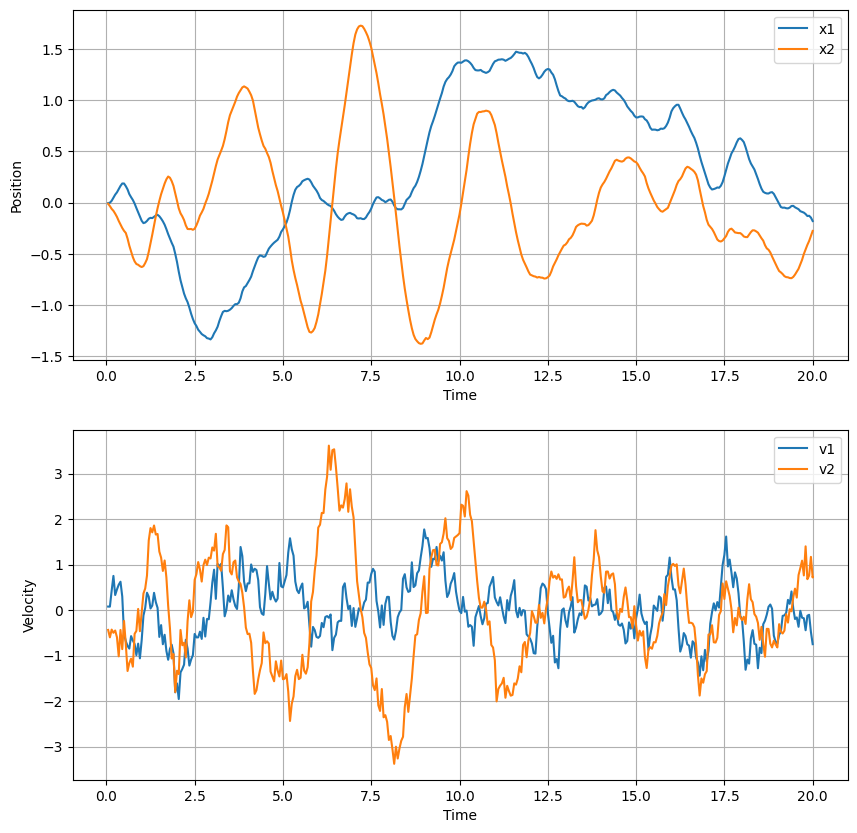

In [8]:
# Plot the trajectory against time and velocity against time in a separate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(sol.ts, xs[:, 0], label="x1")
axs[0].plot(sol.ts, xs[:, 1], label="x2")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Position")
axs[0].legend()
axs[0].grid()

axs[1].plot(sol.ts, vs[:, 0], label="v1")
axs[1].plot(sol.ts, vs[:, 1], label="v2")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Velocity")
axs[1].legend()
axs[1].grid()

plt.show()